# Model Comparison Notebook

Compare regression results across saved models. Looks for `model_outputs/`, `model_outputs_xgb/`, `model_outputs_xgb_lgb/`, `model_outputs_xgb_lgb` or similar and aggregates metrics.

In [1]:
from pathlib import Path
import json
import pandas as pd
ROOT = Path.cwd()
candidates = [
    ROOT / 'model_outputs' / 'regression_results.json',
    ROOT / 'model_outputs_xgb' / 'regression_metrics.json',
    ROOT / 'model_outputs_xgb_lgb' / 'regression_results_xgb_lgb.json',
    ROOT / 'model_outputs_xgb_lgb' / 'regression_results.json',
    ROOT / 'model_outputs' / 'regression_results_xgb_lgb.json'
]
found = []
for p in candidates:
    if p.exists():
        found.append(p)
print('Found metric files:', found)


Found metric files: [PosixPath('/Users/parthpatel/Mtech/DA_204o_Project/model_outputs/regression_results.json')]


In [2]:
# load all found metric files and normalize into a dataframe
rows = []
for p in found:
    try:
        data = json.loads(p.read_text())
        # if file is a dict of model:metrics or metrics
        if isinstance(data, dict):
            # if it's per-model dict (like {'Linear':{...}, 'RandomForest':{...}})
            # flatten
            for k,v in data.items():
                if isinstance(v, dict):
                    row = {'source_file': p.name, 'model': k}
                    row.update(v)
                    rows.append(row)
                else:
                    # single-model metrics
                    row = {'source_file': p.name, 'model': p.stem}
                    row.update(data)
                    rows.append(row)
        else:
            # skip
            pass
    except Exception as e:
        print('Failed to read', p, e)

if rows:
    df_metrics = pd.DataFrame(rows)
    df_metrics = df_metrics[['source_file','model','MAE','RMSE','R2']].drop_duplicates()
    display(df_metrics)
    df_metrics.to_csv(ROOT / 'model_comparison.csv', index=False)
    print('Saved model_comparison.csv')
else:
    print('No metrics loaded to compare. Run training notebooks first.')

,source_file,model,MAE,RMSE,R2
0,regression_results.json,Linear,0.265041,0.370549,0.904410
1,regression_results.json,RandomForest,0.104844,0.308720,0.933649
2,regression_results.json,XGBoost,0.111583,0.298919,0.937795
3,regression_results.json,LightGBM,0.112999,0.310297,0.932969


Saved model_comparison.csv


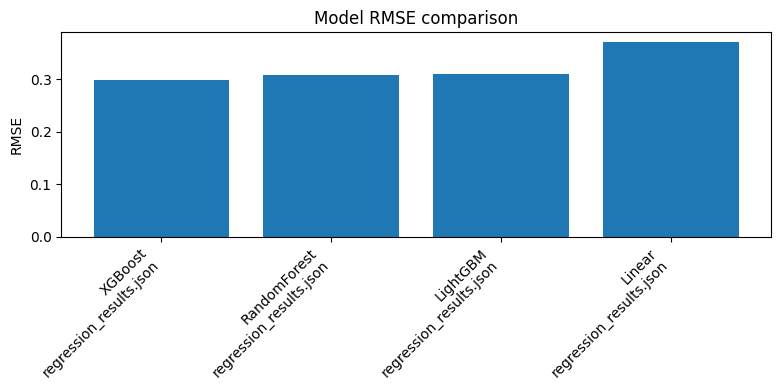

In [3]:
# Quick visualization (bar plot of RMSE)
import matplotlib.pyplot as plt
if 'df_metrics' in globals() and not df_metrics.empty:
    df_plot = df_metrics.sort_values('RMSE')
    plt.figure(figsize=(8,4))
    plt.bar(df_plot['model'] + '\n' + df_plot['source_file'], df_plot['RMSE'])
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('RMSE')
    plt.title('Model RMSE comparison')
    plt.tight_layout()
    plt.savefig(ROOT / 'model_comparison_rmse.png', dpi=150)
    plt.show()
else:
    print('No metrics to plot')